In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model

import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')   # 定义数据格式
K.set_learning_phase(1)
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import scipy.misc

import pydot
from IPython.display import SVG
from tensorflow.keras.utils import plot_model

from tensorflow.keras import regularizers    # 正则项


# import resnets_utils 

%matplotlib inline

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

img_w = 128
img_h =128

# 本地权重参数
# local_weights_file = r'D:\大创\tensorflow\模型参数\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Resnet模型相关设置
pre_trained_model = InceptionV3(include_top=False,
                             weights='imagenet',
                             input_shape=(img_w,img_h,3)
                             )

# 导入本地权重参数
# pre_trained_model.load_weights(local_weights_file)

# 全部冻结
#for layer in pre_trained_model.layers:
#  layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [3]:
# 自己选择哪一层作为最后一层
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 2, 2, 2048)


In [4]:
# 回调函数
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

   

In [5]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

# Flatten the output layer to 1 dimension
# 添加扁平层，把last_layer(用户选择的最后一层)拉直
x = layers.GlobalAveragePooling2D()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

x = layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x) # ,kernel_regularizer=regularizers.l2(0.01)

x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)

# 自定义新模型
model = Model( pre_trained_model.input, x)

model.compile(loss = 'binary_crossentropy', optimizer=RMSprop(lr=0.0002), metrics=['accuracy'])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
# import zipfile

# Define our example directories and files
train_dir = r'D:\大创\img\train1'
validation_dir = r'D:\大创\img\test1'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,   # 归一化
                                   rotation_range = 40,  # 旋转 0~40°
                                   width_shift_range = 0.2,  # 水平移动 0~ 20%
                                   height_shift_range = 0.2,  # 竖直移动0~20%
                                   shear_range = 0.2,     # 允许剪切，变形
                                   zoom_range = 0.2,        # 缩放0~20%
                                   horizontal_flip = True)  # 水平翻转

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 16,
                                                    class_mode = 'binary',
                                                    target_size = (img_w, img_h))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 8,
                                                          class_mode  = 'binary',
                                                          target_size = (img_w, img_h))


Found 84 images belonging to 2 classes.
Found 14 images belonging to 2 classes.


In [8]:
callbacks = myCallback()

history = model.fit(
    train_generator, 
    epochs=100,
    # steps_per_epoch=43,   # 5391/128
    validation_data = validation_generator, 
    verbose = 1, 
    # validation_steps=16,  # 1002/64
    # callbacks=[callbacks]
)

Epoch 1/100
6/6 [==============================] - 1s 147ms/step - loss: 8.5728 - accuracy: 0.9405 - val_loss: 12.1701 - val_accuracy: 0.4286
Epoch 2/100
6/6 [==============================] - 1s 138ms/step - loss: 8.3435 - accuracy: 0.8571 - val_loss: 9.0375 - val_accuracy: 0.7143
Epoch 3/100
6/6 [==============================] - 1s 139ms/step - loss: 7.7732 - accuracy: 0.9405 - val_loss: 9.3761 - val_accuracy: 0.6429
Epoch 4/100
6/6 [==============================] - 1s 138ms/step - loss: 7.3415 - accuracy: 0.9762 - val_loss: 9.5479 - val_accuracy: 0.6429
Epoch 5/100
6/6 [==============================] - 1s 139ms/step - loss: 6.9420 - accuracy: 0.9643 - val_loss: 7.8665 - val_accuracy: 0.6429
Epoch 6/100
6/6 [==============================] - 1s 140ms/step - loss: 6.6031 - accuracy: 0.9167 - val_loss: 7.0857 - val_accuracy: 0.7143
Epoch 7/100
6/6 [==============================] - 1s 141ms/step - loss: 6.0816 - accuracy: 0.9762 - val_loss: 6.5328 - val_accuracy: 0.6429
Epoch 8/100


Epoch 59/100
6/6 [==============================] - 1s 147ms/step - loss: 0.4922 - accuracy: 0.9405 - val_loss: 6.3439 - val_accuracy: 0.4286
Epoch 60/100
6/6 [==============================] - 1s 154ms/step - loss: 0.3068 - accuracy: 0.9881 - val_loss: 5.1563 - val_accuracy: 0.4286
Epoch 61/100
6/6 [==============================] - 1s 144ms/step - loss: 0.5131 - accuracy: 0.9405 - val_loss: 1.7155 - val_accuracy: 0.7143
Epoch 62/100
6/6 [==============================] - 1s 147ms/step - loss: 0.3706 - accuracy: 0.9286 - val_loss: 2.3675 - val_accuracy: 0.5714
Epoch 63/100
6/6 [==============================] - 1s 149ms/step - loss: 0.4553 - accuracy: 0.9405 - val_loss: 1.2498 - val_accuracy: 0.5714
Epoch 64/100
6/6 [==============================] - 1s 146ms/step - loss: 0.3276 - accuracy: 0.9524 - val_loss: 1.2069 - val_accuracy: 0.6429
Epoch 65/100
6/6 [==============================] - 1s 143ms/step - loss: 0.2455 - accuracy: 0.9762 - val_loss: 0.8015 - val_accuracy: 0.7857
Epoch 

In [9]:
#### 对大量数据（validation_generator）进行预测

preds = model.evaluate(validation_generator, verbose=1, sample_weight=None)
print ("误差值 = " + str(preds[0]))
print ("准确度 = " + str(preds[1]))

83/83 [==============================] - 2s 25ms/step - loss: 0.6441 - accuracy: 0.8667 0s - loss: 0.6540 - accuracy: 
误差值 = 0.6441136002540588
准确度 = 0.8666666746139526


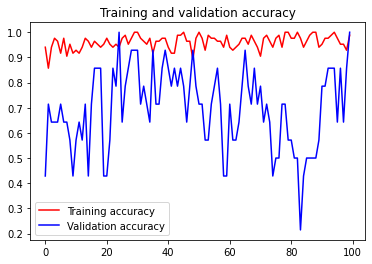

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

<Figure size 432x288 with 0 Axes>

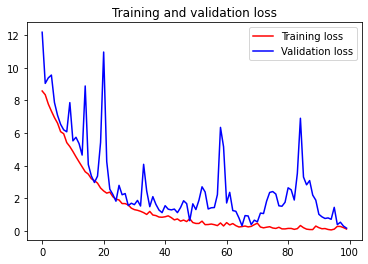

<Figure size 432x288 with 0 Axes>

In [10]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

In [12]:
# 保存模型（结构和参数）
file_path = './' + 'Inception皮肤癌验证集准确率' + str(int(preds[1]*1000)/1000) + '.h5'

print(file_path)

model.save(file_path)

./Inception皮肤癌验证集准确率0.866.h5


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('./皮肤癌验证集准确率0.86.h5')

preds = model.evaluate(validation_generator, verbose=1, sample_weight=None)
print ("误差值 = " + str(preds[0]))
print ("准确度 = " + str(preds[1]))

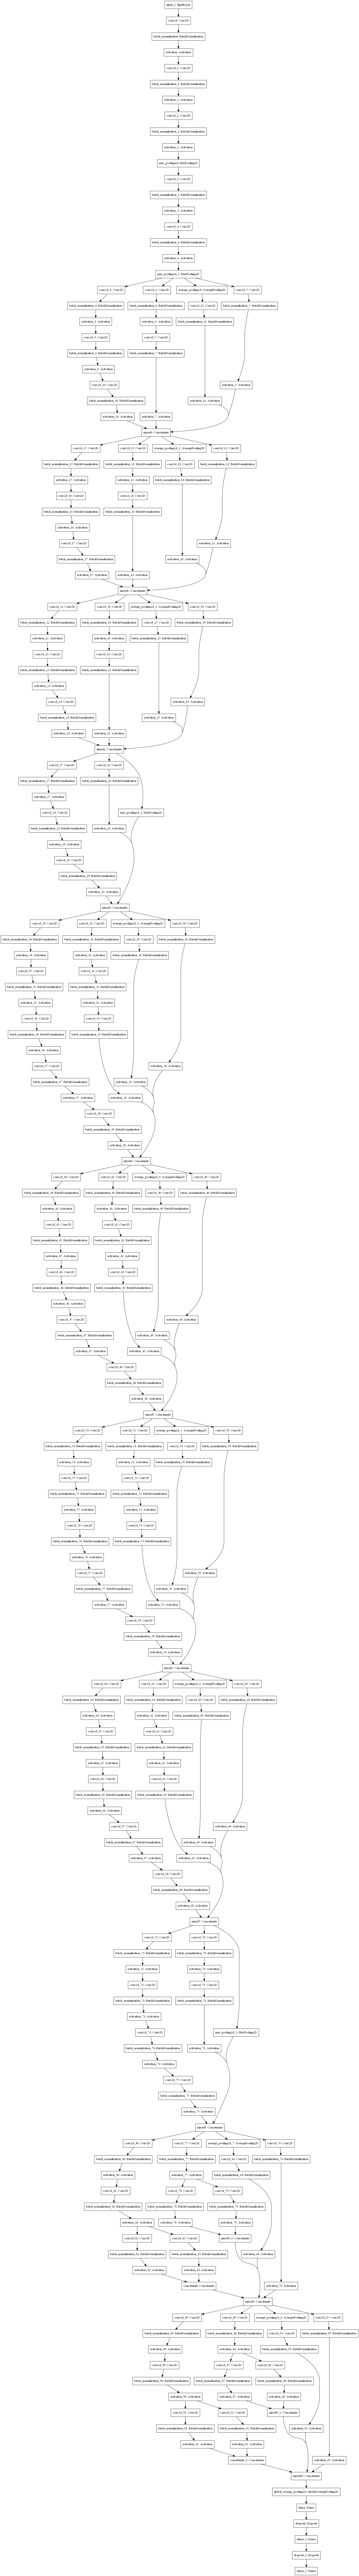

In [7]:

########### 模型可视化


import pydot
from IPython.display import SVG
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png')

# 图片可能很大，把图片复制到其他地方查看